## Introduction

Livia Placinta 887236 |
Vittorio Chinaglia 886605 |
Mark Yasashinyy 884994


The objective of this notebook is to create a code that can **understand the sentiment of a given sentence**. We will use the skill learned during classes and more. The developed sentiment analysis model can be eventually used to analyze chats, social media posts or other digital spaces where the **meaning of what you say is important**.

As a base of our research we will use the dataset containing 1.600.000 tweets made in about 3 months.

These are the steps that will taken during the developement in order to reach our goal:

* **Importing Packages** 
* **Cleaning and Processing the text** 
* **Analyzing and Visualizing the data**
* **Splitting and Vectorising**  
* **Creating and Evaluating the models**
* **Developing and testing the code** 


Let's start with the essentials:



## Importing Dependencies

In [1]:
# utilities
import re
import numpy as np
import pandas as pd
import pickle

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# images
from PIL import Image

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

## Importing dataset
The dataset being used is the **training dataset** downloaded from Kaggle. It contains 1,600,000 tweets that have been assigned a sentiment as **0 = Negative, 4 = Positive**
 
*[The training data isn't perfectly categorised as it has been created by tagging the text according to the emoji present. So, any model built using this dataset may have lower than expected accuracy, since the dataset isn't perfectly categorised.]*

**It contains the following 6 fields:**
1. **sentiment**: the polarity of the tweet *(0 = negative, 4 = positive)*
2. **ids**: The id of the tweet 
3. **date**: the date of the tweet *(Sat April 22 23:58:44 UTC 2009)*
4. **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
5. **user**: the user that tweeted *(robotickilldozr)*
6. **text**: the text of the tweet *(Lyx is cool)*

We require a main dataset containing the **sentiment** and **Text** fields and an auxilary, containing the **Date** and **Sentiment** one for some **future graphs**.

The dataset is already sorted by sentiment. First half negative, second half positive.

In [2]:
# Importing the dataset, specifying the encoding and the names for the columns
dataset = pd.read_csv('training.1600000.processed.noemoticon.csv',
                         encoding="ISO-8859-1" ,
                         names=["Sentiment", "Tweet ID", "Date", "QUERY", "User", "Text"])

# Removing the unnecessary columns and creating datasets for later use.
# Creating the auxillary dataset
aux_dataset = dataset[['Date','Sentiment']]

# Creating the main dataset
main_dataset = dataset[['Sentiment','Text']].copy()

# We replace number 4 with number 1 in the main dataset for easier managing of the data
main_dataset['Sentiment'] = dataset['Sentiment'].replace(4,1)


# Storing data of the text and sentiment in lists for the future modelling
text, sentiment = list(main_dataset['Text']), list(main_dataset['Sentiment'])


<AxesSubplot:xlabel='Sentiment', ylabel='count'>

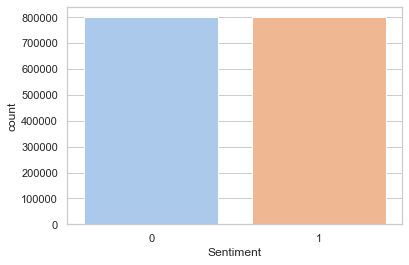

In [3]:
# Plotting the distribution for dataset in order to better visulize what are we dealing with.
sns.set_theme(style='whitegrid')
sns.set_palette ( "pastel")
sns.countplot(x='Sentiment',data=main_dataset)

We want to plot a graph that has X-axis with the date and Y-axis with the amount of tweets labeled with different colors according to its sentiment

In [4]:
# Splitting the auxillary database into two subsets containing only negative and only positive tweets
data_neg = aux_dataset[:800000]
data_pos = aux_dataset[800000:]

# Here we group tweets by day using the dates and summing the amount of tweets made that day for each subset
data_neg_for_plot = (pd.to_datetime(data_neg['Date'])
       .dt.floor('d')
       .value_counts()
       .rename_axis('Date')
       .reset_index(name='count_neg'))
# The same for the second subset
data_pos_for_plot = (pd.to_datetime(data_pos['Date'])
       .dt.floor('d')
       .value_counts()
       .rename_axis('Date')
       .reset_index(name='count_pos'))

# We sort the results by the date
data_neg_for_plot = data_neg_for_plot.sort_values(["Date", "count_neg"], ascending=True)
data_pos_for_plot = data_pos_for_plot.sort_values(["Date", "count_pos"], ascending=True)

/Users/thenotorious/opt/anaconda3/lib/python3.9/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


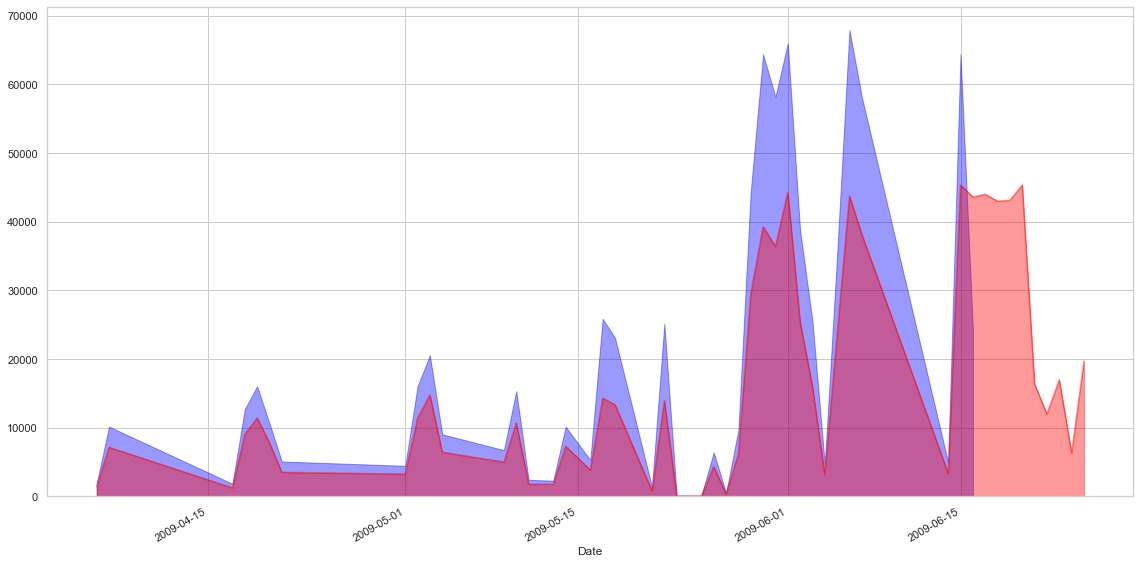

In [5]:
# We start plotting by establishing the wanted size and other parameters
plt.rcParams["figure.figsize"] = [16, 8]
plt.rcParams["figure.autolayout"] = True

sentiment_neg = data_neg_for_plot['count_neg']
sentiment_pos = list(data_pos_for_plot['count_pos'])
dates  = list(data_neg_for_plot['Date'])

# Here we put the second graph on top of the first one in order to merge them seamlesly
fig, ax =  plt.subplots()
ax.stackplot(data_pos_for_plot['Date'], data_pos_for_plot['count_pos'], color='blue', alpha=0.4)
data_neg_for_plot.plot(ax=ax,x='Date', y='count_neg', kind = 'area', color='red', alpha=0.4, legend=False)

plt.show()

## Cleaning and Processing Text

**Text Preprocessing** is an essential step for **Natural Language Processing (NLP)** tasks. It transforms text into a computer friendly form so that machine learning algorithms can perform better and with increased accuracy.

**The Preprocessing steps taken are:**
1. **Lower Casing:** Each text is converted to lowercase to uniform the data.
2. **Replacing URLs:** Links starting with **"http" or "https" or "www"** are replaced by the string **"URL"** to lable all useless links and if needed easily remove them.
3. **Replacing Emojis:** Replace emojis by using a pre-defined dictionary containing emojis along with their meaning.
4. **Replacing Usernames:** Replace '@Usernames' with word **"USER"**.
5. **Removing Non-Alphabets:** Replacing characters except Digits and Alphabets with a space.
6. **Removing Consecutive letters:** 3 or more consecutive letters are replaced by 2 letters. *(eg: "Heyyyy" to "Heyy")*
7. **Removing Short Words:** Words with length less than 2 are removed.
8. **Removing Stopwords:** Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence.
9. **Lemmatizing:** Lemmatization is the process of converting a word to its base form.

In [6]:
# Importing the stopwords from nltk dependence for easier cleaning
from nltk.corpus import stopwords
import nltk
# We doownload the set of stopwords
nltk.download('stopwords')


# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

# Defining set containing all stopwords in english for the following processing of the text.
stopwordlist = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thenotorious/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The main tool that we will use in this step is the RegEx packages which is very useful for cleaning and substitution purpouses. All codes necessary to process tweets will be contained inside our custom function in order to improve code readability.

### Main code to process the text

In [7]:
# Here we create our function that will be use d for the processing of the tweet texts
def preprocess_text(textdata):
    # Create the variable that will contain the processed text
    processedText = []
    
    # Create Lemmatizer and Stemmer for later use.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns using the *re* package of python (found on internet).
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)" # URL substitution
    userPattern       = '@[^\s]+' # USER substitution
    alphaPattern      = "[^a-zA-Z0-9]" # NON ALPHABETS substitution
    sequencePattern   = r"(.)\1\1+" # CONSECUTIVE substitution
    seqReplacePattern = r"\1\1" # REPLACE pattern for consecutive letters
    
    for tweet in textdata:
        # Making all the tweet lowecase
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,'URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,'USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword and if it is we ignore it.
            if word not in stopwordlist:
            #if word not in stopwordlist:
                if len(word)>1:
                    # Lemmatizing the word.
                    word = wordLemm.lemmatize(word)
                    tweetwords += (word+' ')
            
        processedText.append(tweetwords)

        
    return processedText

In [8]:
# Here we use our function to process the text
processedtext = preprocess_text(text)

## Analysing the data
Now we're going to analyse the preprocessed data to get an understanding of it. 

1. See the **least and most used words** in the tweets.
2. Plot **Word Clouds** for **Positive and Negative** tweets from our dataset and see which words occur the most.

### Least used words

In [9]:
# We want to see the rarest words used in our dataset
# Usually they are typos or words from other languages

df_processsed = pd.DataFrame(processedtext)
df_processsed_neg = df_processsed[:800000]


words_main_dataset = pd.Series(" ".join(df_processsed[0]).split()).value_counts()
words_main_dataset.tail(20)

ouble              1
fruttie            1
sakurity           1
squarespaceneed    1
sandale            1
home5              1
looveyy            1
kgn                1
waverace           1
herbag             1
menchion           1
polkadotrobot      1
conseqences        1
8735               1
8736               1
fengyoujing        1
missededed         1
oscillates         1
cmoybb             1
thewdb             1
dtype: int64

### Most used words

In [10]:
words_main_dataset.head(20)

USER      785431
day       106268
good       93059
get        86336
like       79886
go         78437
URL        72722
quot       70296
today      68702
work       68605
love       68229
time       65749
going      64621
got        61292
lol        59227
one        57308
back       57063
know       54093
im         50612
really     50383
dtype: int64

### Word-Cloud for Negative tweets.

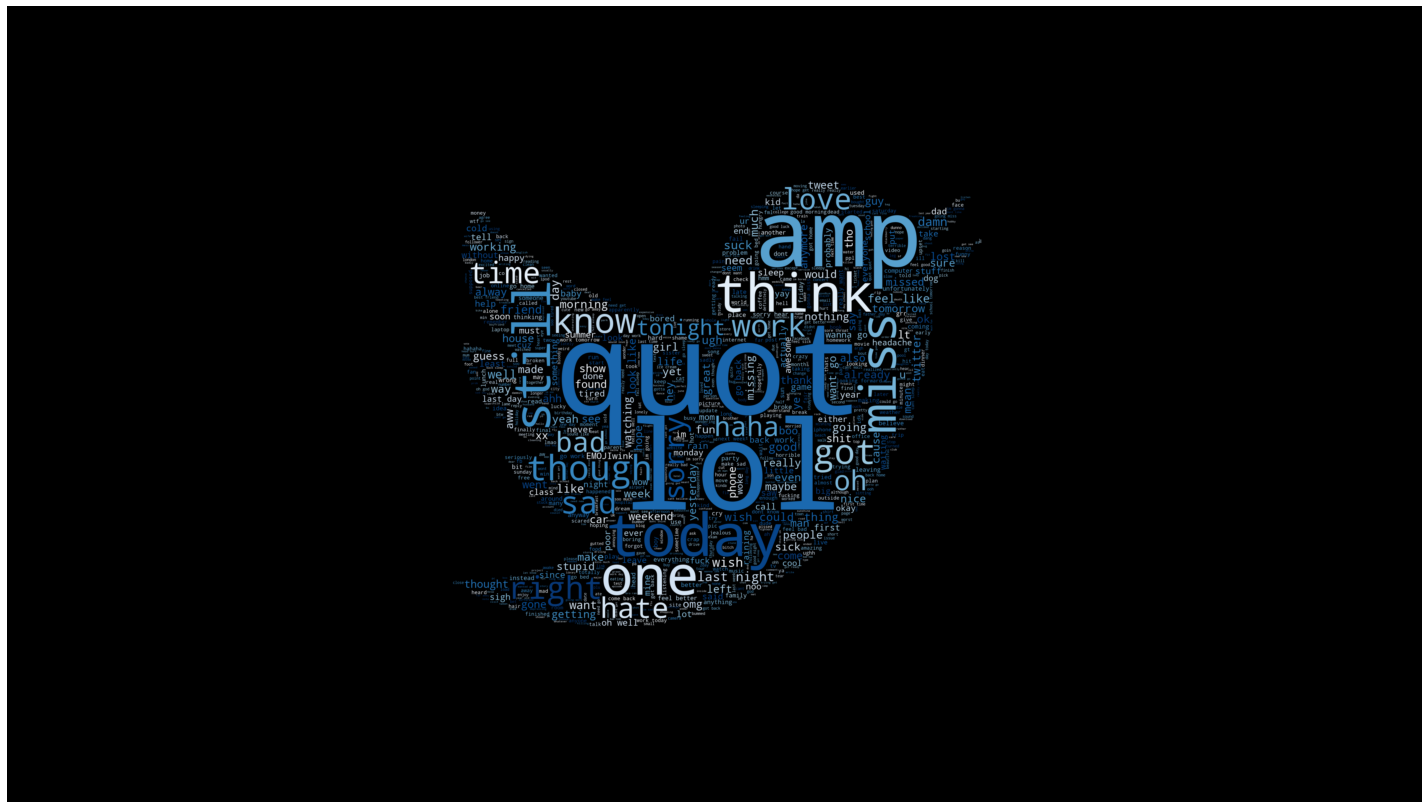

In [16]:
# To visualize the most written words we use a wordcloud
# For the mask we use Twitter logo and Twitter themed colours
# We had to modify the background of the logo to white color(255;255;255) as the mask argument recognizes only this color
mask = np.array(Image.open('twitter_logo_highres.png'))

# We take the negative tweets
data_neg = processedtext[:800000]

# Create the wordcloud
wc = WordCloud(background_color='black',
                mode='RGB',
                mask = mask,
                max_words = 1000,
                width = 1600,
                height = 800,
                colormap='Blues').generate(' '.join(data_neg))



plt.figure(figsize = (20,20))
plt.imshow(wc, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

### Word-Cloud for Positive tweets.

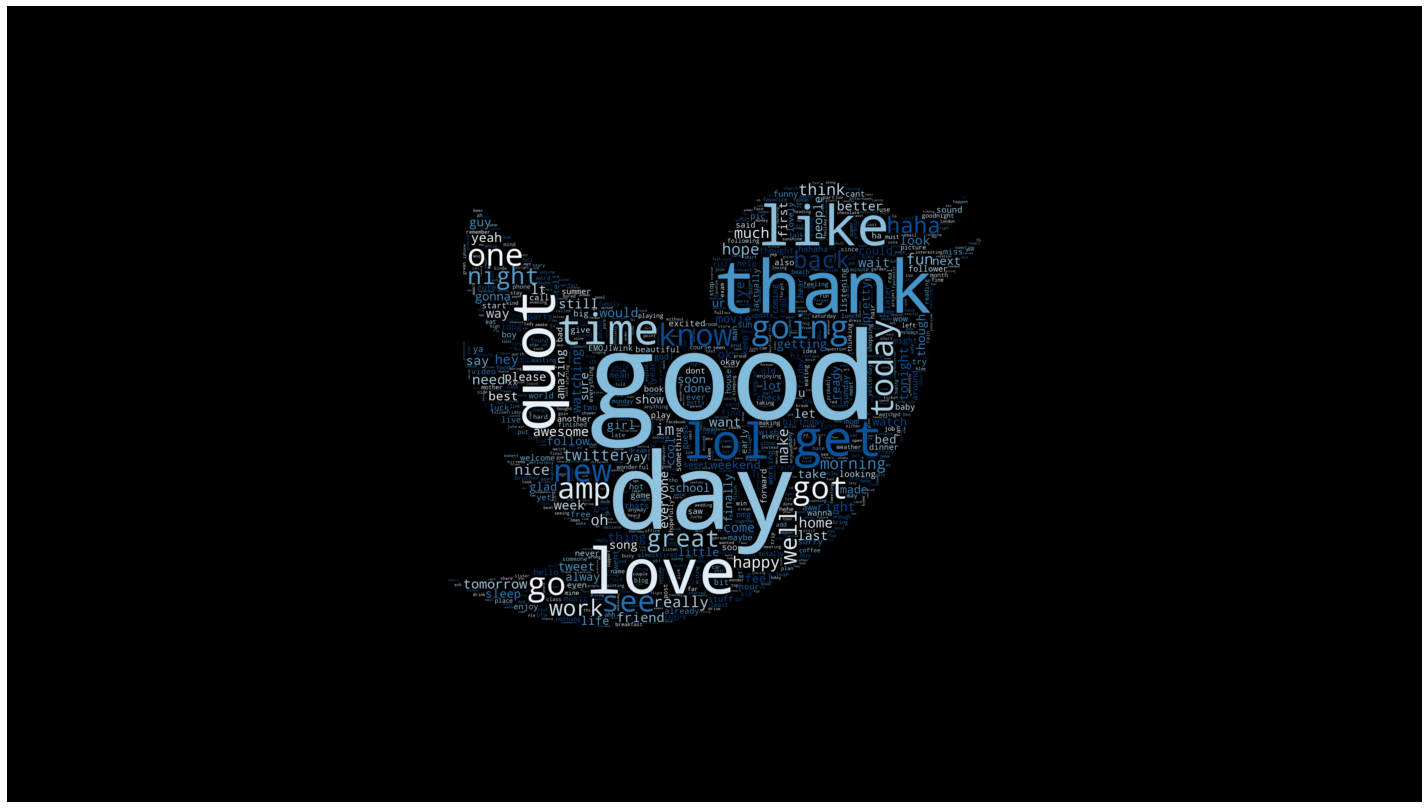

In [17]:
# The same goes for the words used in positive tweets

data_pos = processedtext[800000:]


wc = WordCloud(mask = mask,
                max_words = 1000 ,
                 width = 1600 ,
                  height = 800,
              collocations=False,
              colormap='Blues').generate(" ".join(data_pos))


plt.figure(figsize = (20,20))
plt.imshow(wc, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis('off')
plt.show()

## Classification

### Splitting the Data
The Preprocessed Data is divided into 2 sets of data: 
* **Training Data:** The dataset upon which the model would be trained on. Contains 95% data.
* **Test Data:** The dataset upon which the model would be tested against. Contains 5% data.

In [18]:
# We divide the processed text into training and test subsets
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


### TF-IDF Vectoriser
TF-IDF indicates what the importance of the word is, in order to understand the document or dataset. This is the intuition behind TF-IDF.

**TF-IDF Vectoriser** converts a collection of raw documents to a **matrix of TF-IDF features**. The **Vectoriser** is usually trained on only the **X_train** dataset. 

**ngram_range**  is the range of number of words in a sequence. *[e.g "most beautiful" is a 2-gram that is considered as an extra feature separately from "most" and "beautiful" when you have a n-gram range of (1,2)]*

**max_features** specifies the number of features to consider. *[Ordered by feature frequency across the corpus]*.

In [19]:
# We implement the TF-IDF and assign a wieght to every word depending in its characteristics
# We limit the amount of feature words as to optimize the compiling times
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=800000)
vectoriser.fit(X_train)
print(f'Vectorisation finished.')
print('Number of feature words: ', len(vectoriser.get_feature_names_out()))

Vectorisation finished.
Number of feature words:  3944047


### Tranforming the dataset

In [20]:
# Transforming the X_train and X_test dataset into matrix of TF-IDF Features by using the TF-IDF Vectoriser. 
# This datasets will be used to train the model and test against it.
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


## Creating and Evaluating Models

We're creating 3 different types of model for our sentiment analysis problem: 
* **Bernoulli Naive Bayes (BernoulliNB)**
* **Linear Support Vector Classification (LinearSVC)**
* **Logistic Regression (LR)**

Since our dataset is not **skewed**, i.e. it has equal number of **Positive and Negative** Predictions. We're choosing **Accuracy** as our evaluation metric. Furthermore, we're plotting the **Confusion Matrix** to get an understanding of how our model is performing on both classification types.

### Evaluate Model Function

In [21]:
# Create a function that will simulate our models
def model_Simulation(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

# Create a function that will plot a confusion matrix for a given model
def model_ConfusionMatrix(model):

    y_pred = model.predict(X_test)
    # Compute and plot the Confusion matrix
    confusion_matrix_var = confusion_matrix(y_test, y_pred)

    # Label the categorizes with adequate names
    categories  = ['Negative','Positive']
    group_names = ['True Negative','False Positive', 'False Negative','True Positive']
    group_percentages = ['{0:.2%}'.format(value) for value in confusion_matrix_var.flatten() / np.sum(confusion_matrix_var)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    # Plot the confusion matrix itself
    sns.heatmap(confusion_matrix_var, annot = labels, cmap = 'Blues',fmt = '', xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)



### BernoulliNB Model

We used the Bernoulli model as it is designed for data with just 2 categories instead of other NB models

              precision    recall  f1-score   support

           0       0.79      0.77      0.78     39989
           1       0.78      0.80      0.79     40011

    accuracy                           0.79     80000
   macro avg       0.79      0.79      0.79     80000
weighted avg       0.79      0.79      0.79     80000



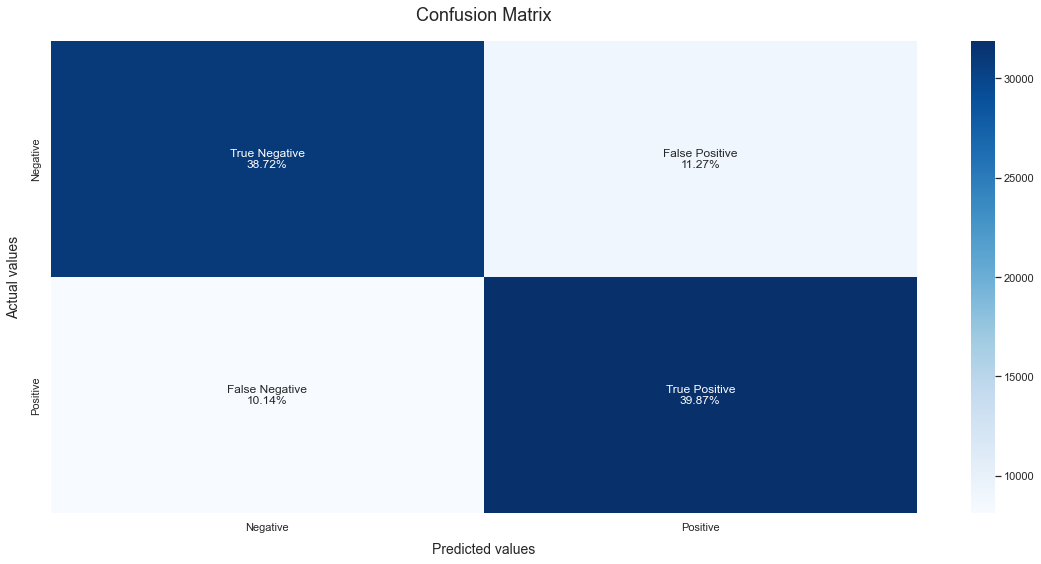

In [22]:
# We use function written before
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Simulation(BNBmodel)
model_ConfusionMatrix(BNBmodel)

In [13]:
# Calculate the error rate of the model as a test

bNb_tn = 38.72
bNb_tp = 39.87
bNb_fn = 10.14
bNb_fp = 11.27

bNb_accuracy = (bNb_fn + bNb_fp)/(bNb_tn + bNb_tp + bNb_fn + bNb_fp)
print(bNb_accuracy)


0.2141


### LinearSVC Model

It works really well with a clear margin of separation. It uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     39989
           1       0.79      0.80      0.79     40011

    accuracy                           0.79     80000
   macro avg       0.79      0.79      0.79     80000
weighted avg       0.79      0.79      0.79     80000



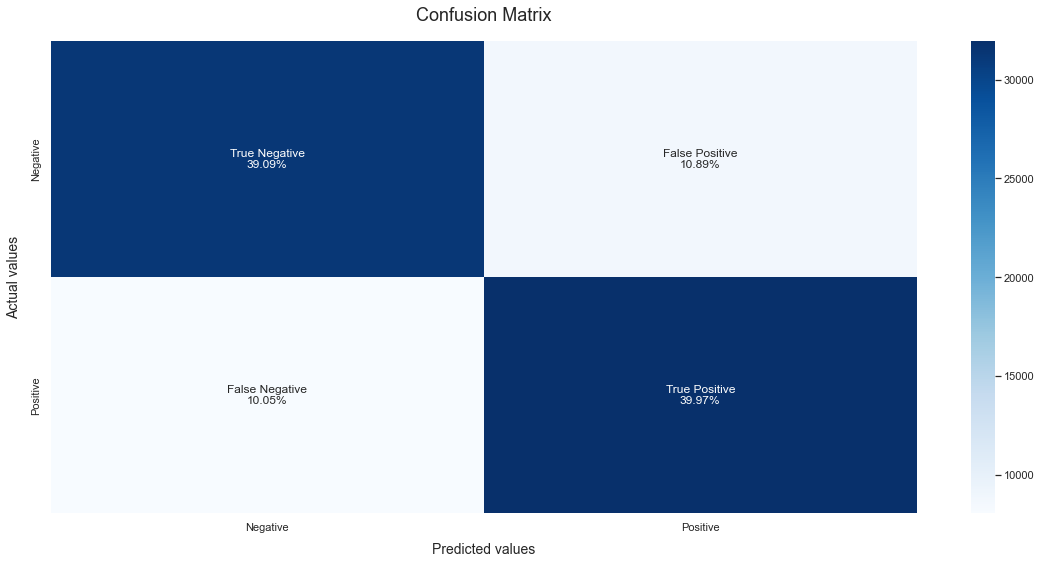

In [23]:
# We use function written before
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Simulation(SVCmodel)
model_ConfusionMatrix(SVCmodel)

### Logistic Regression Model


Logistic Regression is a “Supervised machine learning” algorithm that can be used to model the probability of a certain class or event. It is used when the data is linearly separable and the outcome is binary or dichotomous in nature.

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     39989
           1       0.79      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



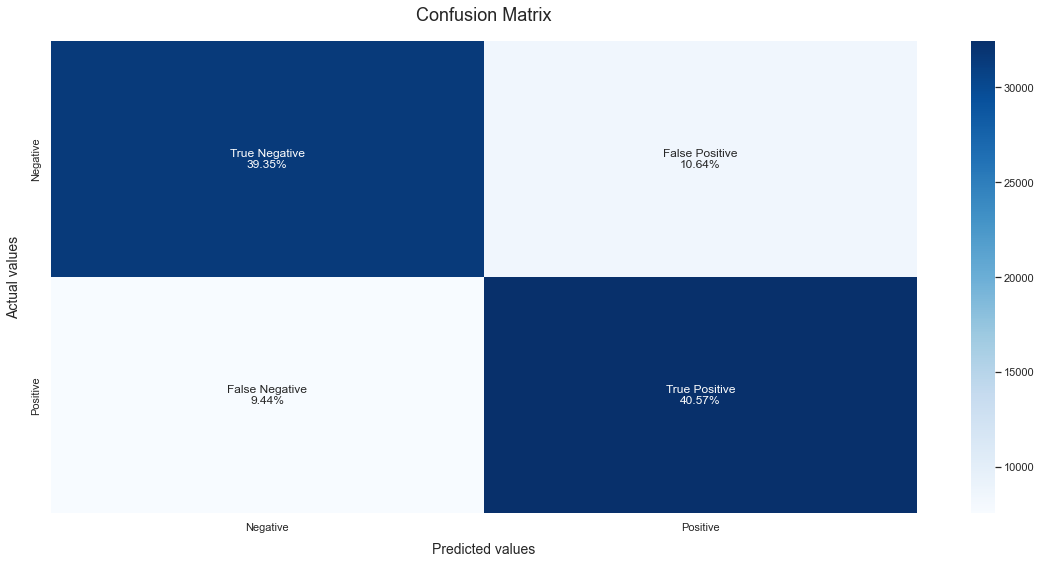

In [24]:
# We use function written before
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Simulation(LRmodel)
model_ConfusionMatrix(LRmodel)

### Plotting

In [25]:
# Update used varibles with original values
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)

# Convert using count vectorizer into matrixes
vt = CountVectorizer(analyzer="word")
X_train_count = vt.fit_transform(X_train)
X_test_count = vt.transform(X_test)

/Users/thenotorious/opt/anaconda3/lib/python3.9/site-packages/yellowbrick/classifier/prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(


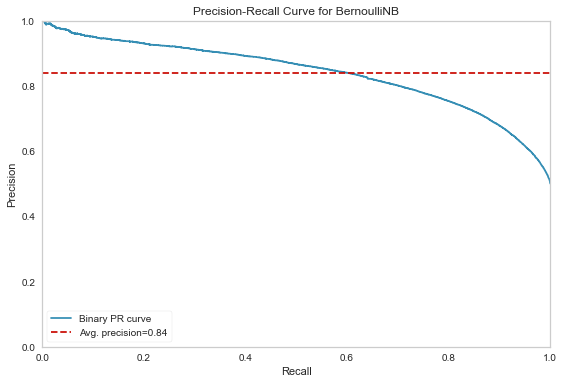

In [26]:
# Import yellow.brick to make precision-recall graphs
from yellowbrick.classifier import PrecisionRecallCurve

# Plot the graph
viz = PrecisionRecallCurve(BernoulliNB(),
                           classes=BNBmodel.classes_,   
                           per_class=True,  
                           cmap="Set1")
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [27]:
# The same goes for the SVC model
viz = PrecisionRecallCurve(BernoulliNB(),
                           classes=SVCmodel.classes_,   
                           per_class=True, 
                           cmap="Set1")
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

/Users/thenotorious/opt/anaconda3/lib/python3.9/site-packages/yellowbrick/classifier/prcurve.py:254: YellowbrickWarning: micro=True is ignored;specify per_class=False to draw a PR curve after micro-averaging
  warnings.warn(
/Users/thenotorious/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


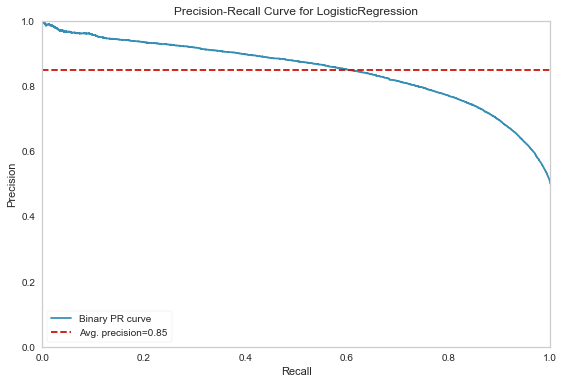

In [28]:
# And for Linear Regression
viz = PrecisionRecallCurve(LogisticRegression(),
                           classes=LRmodel.classes_,
                           per_class=True,
                           cmap="Set1")
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

We can see that the **Logistic Regression Model** performs the best out of all the different models that we tried. It achieves around **80% accuracy** in the classification process. This result is considered good and tells us that all the processes done prior to simulation were done corectly.

Although it should also be noted that the **BernoulliNB Model** is the fastest to train and predict on, it has also achieved nearly **80% accuracy** while calssifying. 

Considering the time and the accuracy the best method overall for our purpouse is **BernoulliNB**.

### Saving the models for quick access in our code

The models are saved using PICKLE to be readily accessible inside our code and to minimize the time of running

In [32]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()

file = open('Sentiment-SVC.pickle','wb')
pickle.dump(SVCmodel, file)
file.close()

## Using the Model

To use the model for **Sentiment Prediction** we need to import the **Vectoriser** and **the chosen model** using **Pickle**.

The vectoriser can be used to transform data to matrix of TF-IDF Features.
While the model can be used to predict the sentiment of the transformed Data.
The text whose sentiment has to be predicted however must be preprocessed.

In [35]:
def load_models():
    
    # Load the vectoriser.
    file = open('vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    # Load the LR Model.
    file = open('Sentiment-LRv1.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()

    file = open('Sentiment-SVC.pickle', 'rb')
    SVCmodel = pickle.load(file)
    file.close()

    file = open('Sentiment-BNB.pickle', 'rb')
    BNBmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel, BNBmodel, SVCmodel

In [36]:
def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess_text(text))
    sentiment = model.predict(textdata)
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

if __name__=="__main__":
    # Loading the models.
    load_models()
    
    # Text to classify.
    text = ["I hate twitter", "I love when it's raining", "Mr.Stark i want to throw up", 'I want to kiss a girl', 'Today is beautiful day']
    
    df = predict(vectoriser, BNBmodel, text)
    print(df.head())

                          text sentiment
0               I hate twitter  Negative
1     I love when it's raining  Negative
2  Mr.Stark i want to throw up  Negative
3        I want to kiss a girl  Positive
4       Today is beautiful day  Positive


### Conclusion

As the result we were able to achieve our goal with a pretty high accuracy rate. Our code is capable of understanding the given text and to clsassify it using different models that are already preloaded.

Thabk you.